CMSC320 Final Project <br>
Counter Strike: Global Offensive eSports Statistic Analysis <br>
Group Members: Jeffrey Rosen, Michael Rosen

Counter Strike: Global Offensive (commonly abbreviated as CS:GO) is a massively popular competitive multiplayer video game with a thriving eSports community. eSports popularity is growing at an unprecedented rate with CS:GO at the forefront. Teams from many countries compete against each other in organized tornaments hosted at various venues around the world.<br><br>
Our motivation behind choosing to analyize eSports statistics is the same motivation behind performing statistical analysis on any other sport (eg: baseball). Strategic applied use of statistical analysis allows for the construction of teams with insanely high win rates at minimal cost to operate. This is the same concept explored in our Moneyball class project. A very insightful further look into the advantages of analytic based decision making can be found here: http://ibit.temple.edu/blog/2014/04/13/sports-analytics-advancing-decision-making-through-technology-and-data/  <br><br>We performed data analysis on statistics such as match wins/losses, kill/death ratios, and kill differentials. Our data is of an international scope. All of our data was scraped and parsed from HLTV, one the communities most regarded media groups.<br><br>The data we utilized can be found here: HLTV.org/Stats. <br> <br>
We used Python's built-in functionality to send HTTP requests that allowed us to retrieve raw HTML table data. Beautiful Soup scraped the data we requested and generated a highly usuable Pandas dataframe. We had to resort to manually using regex to pull the country names from each team since Beautiful Soup wasn't able to parse it for us. The inital problem we had was that HLTV's table presented country data in the form of a flag image instead of plain text. Fortunately, the alt property of the HTML img tags contained the country name text.<br><br>We performed some basic preliminary dataframe sanitation below. Most notably, we removed the team "Tyloo" since they only play exclusively with low performing no name Chinese teams. This anomaly caused massive skews in our data and ruined the integrity of some of our data analyses.

In [1]:
# Import declarations
import math
import re as re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# Get the data
r = requests.get("https://www.hltv.org/stats/teams")

# Create a pandas with pulled data
root = bs(r.content, "html.parser") 
root.prettify()
table = (str)(root.find("table"))
teams = pd.read_html(table, header=0)[0]

# Pull the country data out of the table and put into our dataframe
table = table.strip("\\n")
countries = (re.findall('title="(.+)"/>', table))
teams['Country'] = pd.Series(countries)

# Clean up columns
teams.columns = ['Team', 'Maps', 'K/D Differential', 'K/D', 'Rating', 'Country']
teams = teams[['Team', 'Country', 'Maps', 'K/D Differential', 'K/D', 'Rating']]

# Delete Tyloo from dataframe for reasons mentioned above
teams = teams.drop([0])

# Get a series with all team names
teamlist = teams[teams.columns[0]]

# Display resultant panda
teams

,Team,Country,Maps,K/D Differential,K/D,Rating
1,Space Soldiers,Turkey,607,5091,1.10,1.07
2,FaZe,Europe,439,2124,1.06,1.06
3,NiP,Sweden,1232,11763,1.12,1.06
4,Kinguin,Poland,542,3292,1.07,1.05
5,Astralis,Denmark,445,3550,1.09,1.05
6,Luminosity,Brazil,572,3855,1.08,1.05
7,G2,France,653,1699,1.03,1.05
8,TSM,Denmark,504,2863,1.07,1.04
9,Titan,France,484,1269,1.03,1.04
10,OpTic,North America,465,2177,1.06,1.04


Next we performed a process similar to the one above to construct a dataframe containing information of the players in each of the top ten teams. HLTV convieniently provided us with a page listing all professional players. We used Beautiful Soup convert the raw HTML data into a easily workable pandas dataframe. We filtered out all of the players that weren't in HLTV's top 10 ranked teams list. Finally, we sorted the dataframe by team name so that players from the same team get grouped together.

In [2]:
# Get the data
r = requests.get("https://www.hltv.org/stats/players")

# Create a pandas with pulled data
root = bs(r.content, "html.parser") 
root.prettify()

# Pull the player data out of the table and put into our dataframe
table = (str)(root.find("table"))
players = pd.read_html(table, header=0)[0]

# An array containing a list of top 10 teams (according to HLTV's critically acclaimed ranking system)
topTeams = ['SK', 'FaZe', 'Astralis', 'NiP', 'Cloud9', 'G2', 'North', 'Virtus.pro', 'fnatic', 'Liquid']

# Discard player information for anyone not listed in the top 10 teams
players = players[players['Team'].isin(topTeams)]

players = players.sort_values('Team')

# Display resultant panda
players


,Player,Team,Maps,K/D Diff,K/D,Rating1.0
221,Xyp9x,Astralis,1185,1532,1.08,1.03
17,device,Astralis,1011,3950,1.24,1.16
122,Kjaerbye,Astralis,889,1707,1.11,1.07
285,gla1ve,Astralis,851,345,1.02,1.00
68,dupreeh,Astralis,1128,2762,1.14,1.10
102,autimatic,Cloud9,649,1302,1.11,1.08
175,RUSH,Cloud9,673,876,1.08,1.04
114,tarik,Cloud9,750,1280,1.10,1.07
106,Skadoodle,Cloud9,827,2323,1.19,1.08
110,Stewie2K,Cloud9,620,961,1.09,1.08


We made a graph representing kill/death ratio for each country. The data has been standardized so that conclusions can easily be made.<br><br>The plot below shows us that Russia has been struggling, while countries like Turkey and Sweden have been prospering. The average kill/death ratio for the teams analyzed below is above 1 since we are only processing data for the upper echelon of teams from their countries. More specifically, countries without teams in the upper 30 of kill/death ratio are not represented.

In [9]:
# Compute standardized Kill/Death ratio for every country using groupby clauses
g = teams.groupby("Country")
kd = g.mean()['K/D']
avg = kd.mean()
std = kd.std()
normalized_kd = []
for c in kd:
    normalized_kd.append((c-avg)/std)
    
ts = teams['Country'].sort_values().unique()
temp = pd.DataFrame({'teams': ts, 'kd': normalized_kd})

print("Average kill/death ratio of teams given: ", avg)

# Create scatter plot of team win ratio (by country)
ax = temp.plot(kind='bar',x='teams',y='kd', title='Scatter Plot of Team Win Ratio Color Coded (By Country)', width = 1)
ax.set_xlabel('Country')
ax.set_ylabel('Standardized Kill/Death Ratio')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

We scraped the match records fo the top 10 ranked teams based on each year to get their win rate for each year. We also deleted useless columns to make the dataframe more readable.  

In [4]:
i = 0
masterDF = pd.DataFrame()

# Top teams
topTeamCountries = ['Brazil', 'EU', 'Denmark', 'Sweden', 'North America', 'France', 'Denmark', 'Russia', 'Sweden', 'North America']

# Top team URLS (for scraping match data)
topTeamMatches = ['https://www.hltv.org/stats/teams/matches/6137/SK', 'https://www.hltv.org/stats/teams/matches/6667/FaZe', \
                    'https://www.hltv.org/stats/teams/matches/6665/Astralis', 'https://www.hltv.org/stats/teams/matches/4411/NiP', \
                    'https://www.hltv.org/stats/teams/matches/5752/Cloud9', 'https://www.hltv.org/stats/teams/matches/5995/G2', \
                    'https://www.hltv.org/stats/teams/matches/7533/North?startDate=2017-01-01&endDate=2017-12-31', 'https://www.hltv.org/stats/teams/matches/5378/Virtus.pro', \
                    'https://www.hltv.org/stats/teams/matches/4991/fnatic', 'https://www.hltv.org/stats/teams/matches/5973/Liquid']

# Go through each of the top 10 teams match data, sanitize/clean it, and throw the match data into one unified master dataframe
for team in topTeamMatches :
    
    # Pull/scrape/parse data
    r = requests.get(team)
    root = bs(r.content, "html.parser") 
    root.prettify()
    table = (str)(root.find("table"))
    SK = pd.read_html(table, header=0)[0]
    
    # Give columns proper names
    SK.columns = ['Date', 'Event', 'Opponent', 'Map', 'Rating', 'W/L', 'Outcome']
    
    # Clean win/loss data and turn to numeric format for compatibilty with machine learning classifier
    SK.loc[SK.Outcome == 'W', 'Outcome'] = 1
    SK.loc[SK.Outcome == 'L', 'Outcome'] = 0
    SK.loc[SK.Outcome == 'T', 'Outcome'] = 0
    
    # Misc sanitation (datetime conversion, typecasting)
    SK['Outcome'] = SK['Outcome'].astype(str).astype(int)
    SK['Event'] = SK['Event'].astype(str)
    SK['Date'] = pd.to_datetime(SK['Date'])
    SK['Year'] = SK['Date'].dt.year
    SK['Team'] = topTeams[i]
    masterDF = masterDF.append(SK)
    i += 1
    
# Reset indexes so that they are from 0 to N instead of being random jumbled numbers
masterDF = masterDF.reset_index(drop=True)

# Drop unneeded colums and clean up names of other columns
masterDF = masterDF.drop(['Event', 'Opponent'], axis=1)
masterDF = masterDF.rename(index=str, columns={"Map" : "Opponent", "Rating" : "Map"})
cols = masterDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
masterDF = masterDF[cols]

# Print resultant dataframe of all merged together top 10 team historic match results
masterDF

,Team,Date,Opponent,Map,W/L,Outcome,Year
0,SK,2017-10-12,FaZe,Train,19 - 16,1,2017
1,SK,2017-10-12,FaZe,Mirage,16 - 9,1,2017
2,SK,2017-10-12,FaZe,Overpass,16 - 11,1,2017
3,SK,2017-10-12,FaZe,Inferno,13 - 16,0,2017
4,SK,2017-09-12,Misfits,Overpass,16 - 1,1,2017
5,SK,2017-09-12,Misfits,Cobblestone,16 - 6,1,2017
6,SK,2017-06-12,Misfits,Cache,16 - 7,1,2017
7,SK,2017-06-12,NRG,Cache,16 - 9,1,2017
8,SK,2017-06-12,NiP,Overpass,16 - 9,1,2017
9,SK,2017-05-12,OpTic,Mirage,14 - 16,0,2017


Next, we processed the data to create a visual representation of the top 10 team win rates. Our graph is doesn't include the year 2012 (or prior) since NiP is only team that has persistently been rated as a top 10 team since the birth of eSports.<br><br>NiP is known for their exceptional performance and have a lot of hype behind their name. We printed out their winrates for all of the years they have been active. Most notably, NiP had a absolutely legendary 87-0 win streak in 2012 giving them a win percentage of 98%. Our data shows that they are clearly by the best team of 2012.<br><br>Our graph has some teams plotted for a limited range of years. These teams are ones that weren't formed during the inception of professional eSports or teams that have joined new team orginization.<br><br>Many conclusions can be made from this graphical representation. The most significant conclusions that I personally made at first glance is that after NiP's performance dropped significantly after their legendary 2012 run and has remained stagnant ever since. Another conclusion that can be made is that SK's performance during 2015 and every year since has been phenomenal and continues to increase every year. These two significant changes are best explained by major team roster changes that have been made over the course of time.

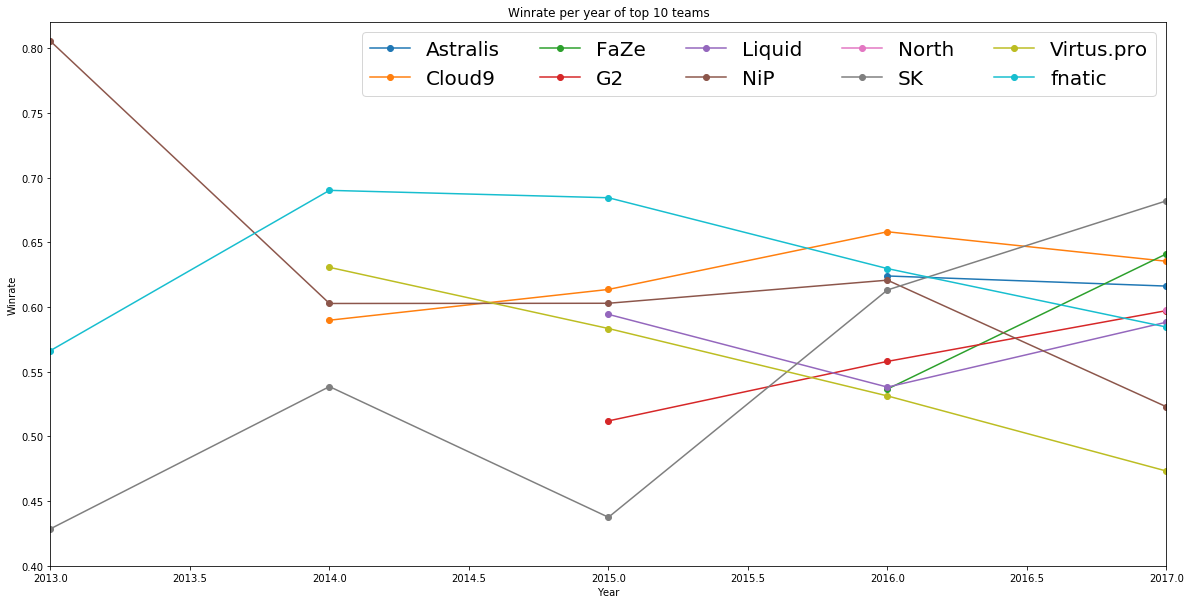

NiP winrate in 2012 :  0.984375
NiP winrate in 2013 :  0.8053435114503816
NiP winrate in 2014 :  0.6026785714285714
NiP winrate in 2015 :  0.6028368794326241
NiP winrate in 2016 :  0.6206896551724138
NiP winrate in 2017 :  0.5228426395939086


In [5]:
# Get Outcome groups for Team, Year
chanz = masterDF.groupby(['Team','Year'])['Outcome'].mean()
cha = chanz.to_frame()
cha['o'] = chanz.index.get_level_values('Team')
cha['f'] = chanz.index.get_level_values('Year')

cha = cha.reset_index(drop=True)
cha = cha.rename(columns={'Outcome': 'Outcome', 'o': 'Team', 'f': 'Year'})

# Group by team and get unique
ts = cha.groupby('Team')
names = ts['Team'].unique()
flat_names = [item for sublist in names for item in sublist]

# Format plot
plt.figure(figsize=(20,10))
plt.xlim(2013,2017)
plt.ylim(.4, .82)
plt.title("Winrate per year of top 10 teams")
plt.ylabel('Winrate')
plt.xlabel('Year')

# Plot for each team
for k,v in ts:
    plt.plot(v['Year'], v['Outcome'],marker='o')
    
plt.legend(flat_names, ncol=5, prop={'size': 20})

# Show aformentioned plot
plt.show()

# Print out significant data about NiP
wrs = ts.get_group('NiP')['Outcome'].tolist()
years = ['2012','2013','2014','2015','2016','2017']

for i in range(0,6):
    print("NiP winrate in", years[i], ": ", wrs[i])

We obtained the means and maxes of the Kill/Death Differential for each team by using GroupBy clauses. We generated a bar graph showing the how the best player on the team did compared to all of the players on the team. We print the means of the K/D Differential and the max K/D Differential. This leads us to an interesting concludion. Notice how one player usually does a lot better than the rest. This usually occurs because teams try to put their "star" player in the best senarios to carry the team for part of the game while sacrificing some of their own stats to either facilitate kills for the other player or to hold a more volatile position on the map where they are less likely to do well. We then printed out the percentage of how much better the star player did than the rest of the team. Notice how they are usually around mid 50%'s with North having the lowest by far of 26.83%. This shows us that North is a team where each player does really well and has no real "star" player but instead 3-4 players per game that are doing well.

Means of K/D Difference per team
 Team
Astralis      2059.2
Cloud9        1348.4
FaZe          1931.4
G2            2184.4
Liquid         816.4
NiP           2667.4
North          703.6
SK            1910.0
Virtus.pro    1170.4
fnatic        1606.8
Name: K/D Diff, dtype: float64

Maxs of K/D Difference per team
 Team
Astralis      3950
Cloud9        2323
FaZe          3962
G2            4852
Liquid        1502
NiP           5009
North         2622
SK            3715
Virtus.pro    2192
fnatic        3006
Name: K/D Diff, dtype: int64


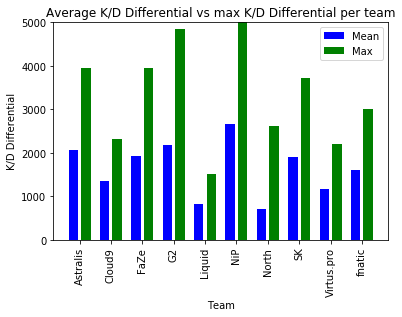

How much better each teams best player did versus average of players on the team
Astralis : 52.13 %
Cloud9 : 58.05 %
FaZe : 48.75 %
G2 : 45.02 %
Liquid : 54.35 %
NiP : 53.25 %
North : 26.83 %
SK : 51.41 %
Virtus.pro : 53.39 %
fnatic : 53.45 %


In [6]:
means = []
maxs = []
teams = players['Team'].sort_values().unique()
stuff = players.groupby('Team')

# Get the means and maxes from the groups and format the columns
means = stuff.mean()
maxs = stuff.max()
means.columns = ['Maps', 'K/D Diff', 'K/D', 'Rating']
maxs.columns = ['Player', 'Maps', 'K/D Diff', 'K/D', 'Rating']

# Print the data I got
print("Means of K/D Difference per team\n", means['K/D Diff'])
print("\nMaxs of K/D Difference per team\n", maxs['K/D Diff'])

# Plot the bar graph with means as blue and maxs as green
ax = plt.subplot(111)
ax.bar([.8,1.8,2.8,3.8,4.8,5.8,6.8,7.8,8.8,9.8], means['K/D Diff'], width=0.3,color='b',align='center')
ax.bar([1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2], maxs['K/D Diff'],width=0.3,color='g',align='center')
plt.xticks([1,2,3,4,5,6,7,8,9,10], teams, rotation='vertical')

# Graph formatting
ax.set_ylim([0, 5000])
ax.legend(['Mean', 'Max'])
plt.title("Average K/D Differential vs max K/D Differential per team")
plt.ylabel('K/D Differential')
plt.xlabel('Team')

plt.show()

me = means['K/D Diff'].tolist()
ma = maxs['K/D Diff'].tolist()

# Print the differences in the star player vs mean players
print("How much better each teams best player did versus average of players on the team")
for i in range(len(me)):
    c = (me[i]/ma[i])*100
    print(teams[i], ": %.2f" %c, "%")


We harnessed the power of machine learning in order to predict future performance of clusters of high performing teams grouped together by country. SKlearn's machine learning classifiers can only take in data that is in numerical format, so I converted the dates to ordinal format (more on what ordinal formatting can be found here: https://en.wikipedia.org/wiki/Ordinal_date. We also use a function that plots the learning curve of a given classifier that was provided in the documentation of SKlearn (as pasted below).

In [7]:
# Convert datetime data to ordinal format so it can be used in our machine learning classisfier
masterDF['Date'] = masterDF['Date'].apply(lambda x: x.toordinal())

# A function that plots a learning curve of a given machine learning classifier (provided by SKLearn documentation)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.legend(loc="best")
    return plt

For our machine learning we decided to lump together a bunch of teams from Europe, America, and Sweden. Europe's top teams are Astralis, North, G2, and FaZe. America's top teams are C9, Liquid, and SK. Sweden's top teams are NiP and fnatic.<br><br>We created handles for SVC learning machine classifiers powered by SKlearn. Documentation and a full description of the SVC machine learning classifier can be found here: http://scikit-learn.org/stable/modules/svm.html. Next, we gave the classifiers the data generated from previous parts of the project to perform the machine learning on. We performed a 10 point cross evaluation on each of the three classifiers. Our 10 point cross evaluation works by splitting up the data we already gave it into 10 pieces and performing a prediction to see if the machine learning classifier is able to produce the correct data. The evaluation returns an array of sucessful prediction percentages for each of the 10 groups. We also provided the cross mean and standard error generated by this evaluation to futher demonstrate how effectively the machine learning classifier is operating. All of this information is printed below.<br><br>Finally, we used our classifiers to predict each country groups win/loss ratios for the next 250 games they play. Not surprisingly, Sweden continues to dominate as they currently do now.

Linear SVM 10 Point Cross Validation On Europe Data
[ 0.49710983  0.52601156  0.40697674  0.48837209  0.44186047  0.4127907
  0.45930233  0.47093023  0.40697674  0.54385965]


Linear SVM 10 Point Cross Validation On America Data
[ 0.46258503  0.34693878  0.27891156  0.27891156  0.34693878  0.48979592
  0.52739726  0.50684932  0.53424658  0.49655172]


Linear SVM 10 Point Cross Validation On Sweden Data
[ 0.42672414  0.51948052  0.41125541  0.23913043  0.57826087  0.5826087
  0.53913043  0.52608696  0.53913043  0.53043478]


Linear SVM Cross Mean and Standard Error For Europe Data
Accuracy: 0.47 (+/- 0.09)


Linear SVM Cross Mean and Standard Error For America Data
Accuracy: 0.43 (+/- 0.19)


Linear SVM Cross Mean and Standard Error For Sweden Data
Accuracy: 0.49 (+/- 0.20)


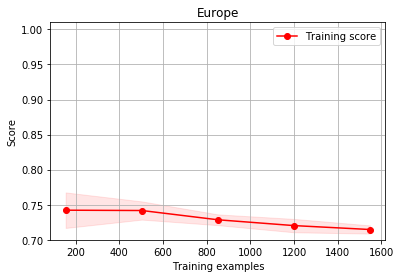

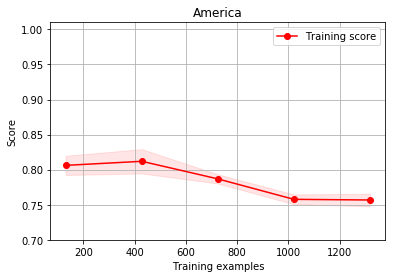

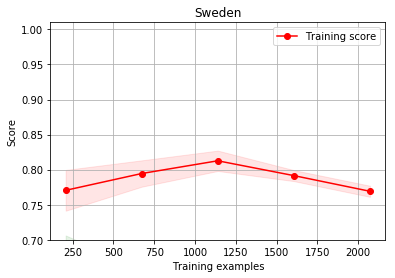

179
Predicted Outcome of Next 250 Games By Best European Teams (Astralis, North, G2, and FaZe)


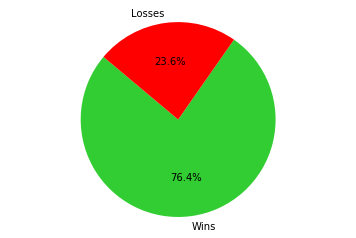

Predicted Outcome of Next 250 Games By Best American Teams (C9, Liquid, and SK)


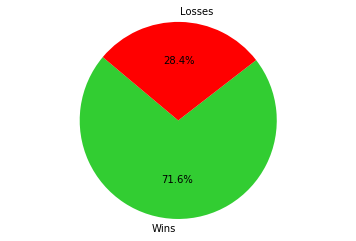

Predicted Outcome of Next 250 Games By Best Swedish Teams (NiP and fnatic)


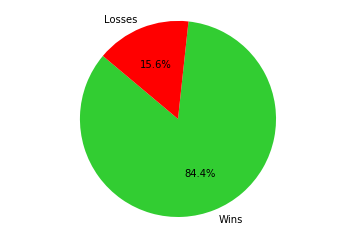

In [8]:
# Lump groups of countries together for machine learning purposes
europe = masterDF[(masterDF.Team == 'Astralis') | (masterDF.Team == 'North') | (masterDF.Team == 'G2') | (masterDF.Team == 'FaZe')]
america = masterDF[(masterDF.Team == 'C9') | (masterDF.Team == 'Liquid') | (masterDF.Team == 'SK')]
sweden = masterDF[(masterDF.Team == 'NiP') | (masterDF.Team == 'fnatic')]

# Create SKlearn machine learning classifier
eursvc = svm.SVC()
amersvc = svm.SVC()
swedsvc = svm.SVC()

# Give the machine learning classifiers the training data
eursvc.fit(europe.Date.values.reshape((len(europe),1)), europe.Outcome)
amersvc.fit(america.Date.values.reshape((len(america),1)), america.Outcome)
swedsvc.fit(sweden.Date.values.reshape((len(sweden),1)), sweden.Outcome)

# Perform a cross validation analysis on each of the three country group classifiers
europesvm = cross_val_score(eursvc, europe.Date.values.reshape((len(europe),1)), europe.Outcome, cv=10)
americasvm = cross_val_score(amersvc, america.Date.values.reshape((len(america),1)), america.Outcome, cv=10)
swedensvm = cross_val_score(swedsvc, sweden.Date.values.reshape((len(sweden),1)), sweden.Outcome, cv=10)

# Perform a 10 point cross validation on Europe group
print ("Linear SVM 10 Point Cross Validation On Europe Data")
print(europesvm)
print ("\n")

# Perform a 10 point cross validation on America group
print ("Linear SVM 10 Point Cross Validation On America Data")
print(americasvm)
print ("\n")

# Perform a 10 point cross validation on Sweden group
print ("Linear SVM 10 Point Cross Validation On Sweden Data")
print(swedensvm)
print("\n")

# Cross mean and standard error stats for each country under SVM classifier
print ("Linear SVM Cross Mean and Standard Error For Europe Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (europesvm.mean(), europesvm.std() * 2))
print("\n")

print ("Linear SVM Cross Mean and Standard Error For America Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (americasvm.mean(), americasvm.std() * 2))
print("\n")

print ("Linear SVM Cross Mean and Standard Error For Sweden Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (swedensvm.mean(), swedensvm.std() * 2))

# Plot the learning curves for each of the three country groups
plot_learning_curve(eursvc, "Europe", europe.Date.values.reshape((len(europe),1)), europe.Outcome, ylim=(0.7, 1.01), cv=10, n_jobs=4)
plot_learning_curve(amersvc, "America", america.Date.values.reshape((len(america),1)), america.Outcome, ylim=(0.7, 1.01), cv=10, n_jobs=4)
plot_learning_curve(swedsvc, "Sweden", sweden.Date.values.reshape((len(sweden),1)), sweden.Outcome, ylim=(0.7, 1.01), cv=10, n_jobs=4)

# Show the learning curves
plt.show()

# Initialize win count variables for each predicition
ewincount = 0
awincount = 0
swincount = 0

# Calculate the each country group amount of wins for the next 250 games
for x in range(735621, 735871):
    if eursvc.predict([[x]]) == [1] :
        ewincount += 1

for x in range(735621, 735871):
    if amersvc.predict([[x]]) == [1] :
        awincount += 1
print (awincount)

for x in range(735621, 735871):
    if swedsvc.predict([[x]]) == [1] :
        swincount += 1
        
# Output Europe group predicition results
print("Predicted Outcome of Next 250 Games By Best European Teams (Astralis, North, G2, and FaZe)")
plt.pie([ewincount, 250-ewincount], explode=(0, 0), labels=['Wins', 'Losses'], colors=['limegreen', 'red'],
        autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

# Output America group predicition results
print("Predicted Outcome of Next 250 Games By Best American Teams (C9, Liquid, and SK)")
plt.pie([awincount, 250-awincount], explode=(0, 0), labels=['Wins', 'Losses'], colors=['limegreen', 'red'],
        autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

# Output Sweden group predicition results
print("Predicted Outcome of Next 250 Games By Best Swedish Teams (NiP and fnatic)")
plt.pie([swincount, 250-swincount], explode=(0, 0), labels=['Wins', 'Losses'], colors=['limegreen', 'red'],
        autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

In conclusion, we noticed that top teams that are from more remote areas have statistics that overshadow the top teams in the world. This is because they are constantly playing versus weaker opponents. Sweden is has been and is still a powerhouse in the world scene with popular team Virtus.Pro from Russia being on a large decline. North American teams are still far from the top European teams. NiP used to be the best team by a large margin with an outstanding 98% winrate and a stranglehold on the whole CSGO scene. Now the best team is nowhere as dominant as 2012 NiP. Most teams try to facilitate one player to do the best and carry them to victory, we took a look at how much the best player on the team out performs the average of the whole team. Most teams have a player that does ~50% better than the other players.

Machine learning was able to show us the win/loss ratio for the next 250 games played for a group of top teams from America, Europe, and Sweden. Machine learning tells us that Sweden will continue to dominate in the eSports world

The data on hltv.org was originally taken for data analysis and we were able to scrape it to do some more unique plots and approximation on our own. We used what we know from data curation, parsing, management, exploratory data analysis, machine learning, and gave insights on data. We used all these skills to give analysis on the data we got on Counter Strike: Global Offensive's thriving eSports scene.